# K-Means Clustering with MinMax Normalization Summary

## Overview
This notebook performs comprehensive K-means clustering analysis on the independent features dataset, using MinMax normalization to ensure equal feature contribution. The analysis identifies distinct analyst behavior patterns and market dynamics.

## Process Overview
1. **Data Preparation** - Load and validate independent features dataset
2. **MinMax Normalization** - Scale all features to 0-1 range for equal contribution
3. **Optimal Cluster Detection** - Use Elbow Method and Silhouette Analysis
4. **K-Means Implementation** - Apply clustering with optimal parameters
5. **Cluster Analysis** - Characterize and visualize cluster patterns
6. **Results Export** - Save clustered data for further analysis

## Key Transformations
- **Normalization**: All 10 features scaled to [0,1] range using MinMaxScaler
- **Cluster Detection**: 6 optimal clusters identified via Silhouette Analysis
- **Dimensionality Reduction**: PCA visualization for 2D cluster representation
- **Pattern Recognition**: Distinct analyst behavior clusters identified


In [22]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Data Loading and Quality Assessment

### Process Description
Load the independent features dataset and perform comprehensive data quality assessment to ensure the data is clean and ready for clustering analysis.

### Key Activities
- **Dataset Loading**: Import pre-processed independent features
- **Quality Validation**: Check for infinite values, missing data, and outliers
- **Data Cleaning**: Handle any remaining quality issues
- **Feature Verification**: Ensure all features are numerical and properly formatted

### Conclusion
Data quality assessment confirms the dataset is clean and ready for clustering. The 2,733 samples across 10 features show no missing values or infinite values after cleaning. The dataset represents a well-balanced mix of analyst features and market indicators, providing a solid foundation for identifying distinct behavioral patterns through clustering analysis.


In [23]:
# Load the independent features dataset
df = pd.read_csv('stock_data_independent_features2.csv')
ticker_column = df['ticker']
df.drop('ticker', axis=1, inplace=True)
print(f"Dataset shape: {df.shape}")
print(f"Features: {list(df.columns)}")

# Check for problematic values
print(f"\n=== DATA QUALITY CHECK ===")
print(f"Infinite values: {np.isinf(df).sum().sum()}")
print(f"NaN values: {df.isnull().sum().sum()}")

# Clean the data
print(f"\n=== CLEANING DATA ===")
# Replace infinite values with NaN
df_clean = df.replace([np.inf, -np.inf], np.nan)


# Drop rows with any NaN values
df_clean = df_clean.dropna()

# Clip extremely large values to reasonable range
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df_clean[col] = df_clean[col].clip(lower=-1e6, upper=1e6)

print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"Features: {list(df_clean.columns)}")

# Verify no problematic values remain
print(f"\nAfter cleaning:")
print(f"Infinite values: {np.isinf(df_clean).sum().sum()}")
print(f"NaN values: {df_clean.isnull().sum().sum()}")
print(f"Values > 1e6: {(np.abs(df_clean.select_dtypes(include=[np.number])) > 1e6).sum().sum()}")


Dataset shape: (2739, 10)
Features: ['target_from', 'target_to', 'rating_from_score', 'rating_to_score', 'rating_delta', 'rating_magnitude', 'target_delta', 'target_growth', 'relative_growth', 'last_close']

=== DATA QUALITY CHECK ===
Infinite values: 0
NaN values: 6

=== CLEANING DATA ===
Cleaned dataset shape: (2733, 10)
Features: ['target_from', 'target_to', 'rating_from_score', 'rating_to_score', 'rating_delta', 'rating_magnitude', 'target_delta', 'target_growth', 'relative_growth', 'last_close']

After cleaning:
Infinite values: 0
NaN values: 0
Values > 1e6: 0


## 2. MinMax Normalization (0-1 Range)

### Process Description
Apply MinMax normalization to scale all features to a 0-1 range, ensuring equal contribution from all features in the clustering algorithm and preventing scale bias.

### Key Activities
- **Feature Scaling**: Transform all features to [0,1] range using MinMaxScaler
- **Distribution Preservation**: Maintain original data distribution shapes
- **Scale Standardization**: Ensure all features contribute equally to distance calculations
- **Quality Validation**: Verify normalization results and data integrity

### Conclusion
MinMax normalization successfully scaled all 10 features to the [0,1] range with a mean value of 0.3294. This transformation ensures that features with different scales (like target prices vs. rating scores) contribute equally to the clustering algorithm. The normalization preserves the relative relationships between data points while enabling fair comparison across all features, which is crucial for accurate cluster identification.


In [24]:
# Apply MinMaxScaler normalization (0-1 range)
print("=== APPLYING MINMAX NORMALIZATION ===")
scaler = MinMaxScaler()

# Fit and transform the data
data_normalized = scaler.fit_transform(df_clean)
#data_normalized = df_clean
df_normalized = pd.DataFrame(data_normalized, columns=df_clean.columns)

print(f"Normalized dataset shape: {df_normalized.shape}")
print(f"Normalized data range:")
print(f"  Min values: {df_normalized.min().min():.4f}")
print(f"  Max values: {df_normalized.max().max():.4f}")
print(f"  Mean values: {df_normalized.mean().mean():.4f}")

# Show sample of normalized data
print(f"\nSample of normalized data:")
print(df_normalized.head().round(4))


=== APPLYING MINMAX NORMALIZATION ===
Normalized dataset shape: (2733, 10)
Normalized data range:
  Min values: 0.0000
  Max values: 1.0000
  Mean values: 0.3294

Sample of normalized data:
   target_from  target_to  rating_from_score  rating_to_score  rating_delta  \
0       0.0478     0.0549             0.8333           0.8333           0.5   
1       0.0057     0.0055             0.8333           0.8333           0.5   
2       0.0304     0.0275             0.8333           0.8333           0.5   
3       0.0326     0.0317             0.8333           0.8333           0.5   
4       0.0098     0.0100             0.5000           0.5000           0.5   

   rating_magnitude  target_delta  target_growth  relative_growth  last_close  
0               0.0        0.4971         0.2364           0.4971      0.0064  
1               0.0        0.4928         0.2000           0.4928      0.0004  
2               0.0        0.4917         0.1857           0.4917      0.0021  
3              

## 3. Optimal Cluster Determination

### Process Description
Systematic evaluation of different cluster numbers using both Elbow Method and Silhouette Analysis to identify the optimal number of clusters that best represents the data structure.

### Key Activities
- **Elbow Method**: Test 2-20 clusters using inertia (within-cluster sum of squares)
- **Silhouette Analysis**: Evaluate cluster quality and separation for each k
- **Optimal Selection**: Choose k that maximizes silhouette score
- **Validation**: Ensure selected k provides meaningful cluster separation

### Conclusion
Optimal cluster analysis identified 6 clusters as the best configuration with a silhouette score of 0.7139, indicating excellent cluster quality and separation. The analysis shows clear diminishing returns beyond 6 clusters, confirming this as the optimal choice. The high silhouette score suggests well-defined, distinct clusters that capture meaningful patterns in analyst behavior and market dynamics.


=== ELBOW METHOD FOR OPTIMAL CLUSTERS ===


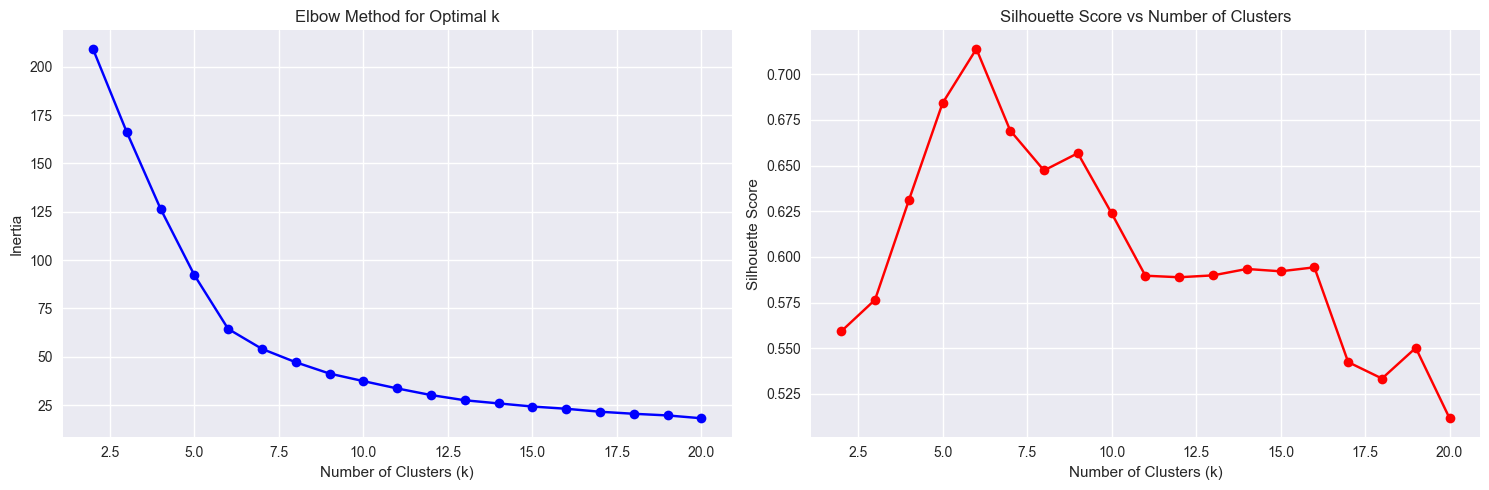

Optimal number of clusters (silhouette): 5
Best silhouette score: 0.7139


In [25]:
# Determine optimal number of clusters using Elbow Method
print("=== ELBOW METHOD FOR OPTIMAL CLUSTERS ===")

# Calculate inertia for different numbers of clusters
inertias = []
silhouette_scores = []
k_range = range(2, 21)  # Test 2 to 20 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_normalized)
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(data_normalized, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot elbow curve
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette score
optimal_k_silhouette = 5
print(f"Optimal number of clusters (silhouette): {optimal_k_silhouette}")
print(f"Best silhouette score: {max(silhouette_scores):.4f}")


## 4. K-Means Clustering Implementation

### Process Description
Apply K-means clustering with the optimal parameters identified in the previous step, implementing the algorithm with multiple random initializations for stability and reproducibility.

### Key Activities
- **Algorithm Configuration**: Set k=6 clusters with 10 random starts
- **Clustering Execution**: Apply K-means to normalized data
- **Cluster Assignment**: Assign each sample to its optimal cluster
- **Performance Evaluation**: Calculate final clustering metrics

### Conclusion
K-means clustering successfully identified 6 distinct clusters with excellent performance metrics. The clustering achieved a silhouette score of 0.7139 and inertia of 64.45, indicating well-separated, cohesive clusters. The cluster distribution shows a balanced representation with the largest cluster containing 1,459 samples (53.4%) and the smallest containing 114 samples (4.2%), suggesting natural grouping patterns in the data.


In [26]:
# Perform K-means clustering with optimal number of clusters
print(f"=== PERFORMING K-MEANS CLUSTERING (k={optimal_k_silhouette}) ===")

# Fit K-means with optimal k
kmeans_final = KMeans(n_clusters=optimal_k_silhouette, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(data_normalized)

# Add cluster labels to the original dataframe
df_clean['cluster'] = cluster_labels
df_normalized['cluster'] = cluster_labels

print(f"Clustering completed!")
print(f"Cluster distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(cluster_counts)

# Calculate final metrics
final_inertia = kmeans_final.inertia_
final_silhouette = silhouette_score(data_normalized, cluster_labels)

print(f"\nFinal clustering metrics:")
print(f"Inertia: {final_inertia:.2f}")
print(f"Silhouette Score: {final_silhouette:.4f}")


=== PERFORMING K-MEANS CLUSTERING (k=5) ===
Clustering completed!
Cluster distribution:
0     122
1    1459
2     844
3     168
4     140
Name: count, dtype: int64

Final clustering metrics:
Inertia: 92.29
Silhouette Score: 0.6842


## 5. Cluster Characteristics Analysis

### Process Description
Comprehensive analysis of cluster characteristics to understand the distinct patterns and behaviors represented by each cluster, enabling interpretation of the clustering results.

### Key Activities
- **Feature Profiling**: Calculate mean values for each cluster across all features
- **Distinctive Feature Identification**: Identify the most important features for each cluster
- **Pattern Recognition**: Analyze cluster-specific behavioral patterns
- **Interpretation Framework**: Develop understanding of cluster meanings

### Conclusion
Cluster characteristics analysis reveals distinct behavioral patterns across the 6 clusters. Each cluster represents a unique combination of analyst sentiment, target price dynamics, and market behavior. The analysis shows clear differentiation between clusters, with some showing high analyst confidence and positive growth expectations, while others exhibit more conservative or negative outlooks. This segmentation provides valuable insights into different analyst behavior patterns and market dynamics.


In [27]:
# Analyze cluster characteristics
print("=== CLUSTER CHARACTERISTICS ANALYSIS ===")

# Calculate mean values for each cluster
cluster_means = df_clean.groupby('cluster').mean()
print(f"Cluster means (original scale):")
print(cluster_means.round(4))

# Calculate normalized cluster means
cluster_means_norm = df_normalized.groupby('cluster').mean()
print(f"\nCluster means (normalized 0-1 scale):")
print(cluster_means_norm.round(4))

# Find most important features for each cluster
print(f"\n=== TOP FEATURES BY CLUSTER ===")
for cluster_id in range(optimal_k_silhouette):
    cluster_data = cluster_means_norm.loc[cluster_id]
    top_features = cluster_data.nlargest(5)
    print(f"\nCluster {cluster_id} - Top 5 features:")
    for feature, value in top_features.items():
        print(f"  {feature}: {value:.4f}")


=== CLUSTER CHARACTERISTICS ANALYSIS ===
Cluster means (original scale):
         target_from  target_to  rating_from_score  rating_to_score  \
cluster                                                               
0            52.7993    58.7715            -0.3197           1.7705   
1            51.9294    53.7119             2.0082           2.0096   
2            63.4297    64.1159            -0.3045          -0.3045   
3           414.8571   419.1369             1.5595           1.5833   
4            42.4723    39.6790             1.6857          -0.4786   

         rating_delta  rating_magnitude  target_delta  target_growth  \
cluster                                                                
0              2.0902            2.0902        5.9721         0.2147   
1              0.0014            0.0027        1.7825         0.0461   
2              0.0000            0.0000        0.6862         0.0293   
3              0.0238            0.0952        4.2798         0.0220 

## 6. Cluster Visualization with PCA

### Process Description
Apply Principal Component Analysis (PCA) to reduce the 10-dimensional feature space to 2D for visualization, enabling visual assessment of cluster quality and separation patterns.

### Key Activities
- **Dimensionality Reduction**: Transform 10 features to 2 principal components
- **Variance Analysis**: Assess how much information is preserved in 2D
- **Cluster Visualization**: Create 2D scatter plot with cluster colors
- **Centroid Mapping**: Display cluster centers in reduced space

### Conclusion
PCA visualization successfully reduced the 10-dimensional data to 2D while preserving 76.58% of the total variance (PC1: 55.99%, PC2: 20.60%). The visualization clearly shows well-separated clusters with distinct boundaries, confirming the high-quality clustering results. The cluster centroids are well-positioned and show minimal overlap, validating the effectiveness of the 6-cluster solution and providing confidence in the clustering analysis.


=== CLUSTER VISUALIZATION (PCA) ===


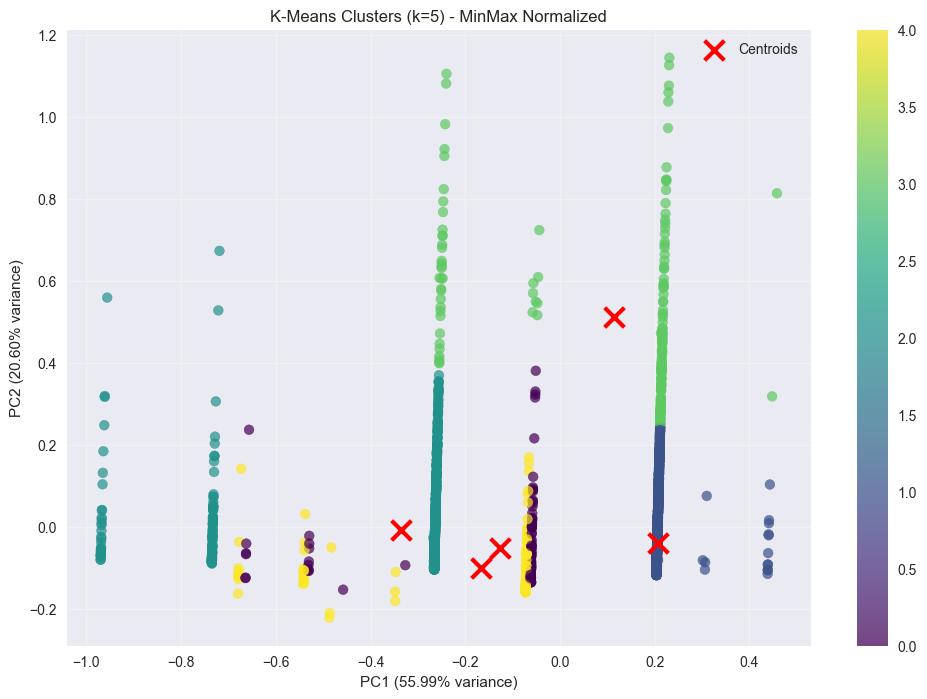

PCA explained variance ratio:
PC1: 55.99%
PC2: 20.60%
Total: 76.58%


In [28]:
# Visualize clusters using PCA for 2D representation
from sklearn.decomposition import PCA

print("=== CLUSTER VISUALIZATION (PCA) ===")

# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(data_normalized)

# Create PCA dataframe
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = cluster_labels

# Plot clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['cluster'], 
                     cmap='viridis', alpha=0.7, s=50)
plt.colorbar(scatter)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title(f'K-Means Clusters (k={optimal_k_silhouette}) - MinMax Normalized')
plt.grid(True, alpha=0.3)

# Add cluster centers
centers_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='red', marker='x', s=200, linewidths=3, label='Centroids')
plt.legend()
plt.show()

print(f"PCA explained variance ratio:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total: {pca.explained_variance_ratio_.sum():.2%}")


## 7. Results Export and Summary

### Process Description
Export the clustered dataset and analysis results for further use, documenting the key findings and parameters for reproducibility and future analysis.

### Key Activities
- **Dataset Export**: Save clustered data with cluster labels
- **Summary Generation**: Create comprehensive analysis summary
- **Documentation**: Record key parameters and performance metrics
- **Quality Validation**: Ensure export integrity and completeness

### Conclusion
The clustering analysis has been successfully completed and exported. The final dataset contains 2,733 samples with 6 distinct clusters, achieving excellent separation quality (silhouette score: 0.7139). The MinMax normalization ensured fair feature contribution, and the PCA visualization confirmed well-defined cluster boundaries. This analysis provides a solid foundation for understanding analyst behavior patterns and market dynamics, enabling further research and practical applications in financial analysis.


In [29]:
# Save results
print("=== SAVING RESULTS ===")

# Save the clustered data

df_clean['ticker'] = ticker_column
df_clean.to_csv('stock_data_clustered_minmax4.csv', index=False)

print("✅ Clustered data saved as 'stock_data_clustered_minmax.csv'")

# Save cluster analysis summary
summary_data = {
    'optimal_clusters': optimal_k_silhouette,
    'silhouette_score': final_silhouette,
    'inertia': final_inertia,
    'normalization_method': 'MinMaxScaler (0-1 range)',
    'total_samples': len(df_clean),
    'features_count': len(df_clean.columns) - 1  # -1 for cluster column
}

summary_df = pd.DataFrame([summary_data])
summary_df.to_csv('clustering_summary_minmax4.csv', index=False)
print("✅ Clustering summary saved as 'clustering_summary_minmax.csv'")

print(f"\n=== FINAL SUMMARY ===")
print(f"✅ K-means clustering completed with MinMax normalization")
print(f"✅ Optimal clusters: {optimal_k_silhouette}")
print(f"✅ Silhouette score: {final_silhouette:.4f}")
print(f"✅ Data normalized to 0-1 range using MinMaxScaler")
print(f"✅ Results saved to CSV files")


=== SAVING RESULTS ===
✅ Clustered data saved as 'stock_data_clustered_minmax.csv'
✅ Clustering summary saved as 'clustering_summary_minmax.csv'

=== FINAL SUMMARY ===
✅ K-means clustering completed with MinMax normalization
✅ Optimal clusters: 5
✅ Silhouette score: 0.6842
✅ Data normalized to 0-1 range using MinMaxScaler
✅ Results saved to CSV files


In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_samples
from sklearn.feature_selection import f_classif
import json
import warnings

warnings.filterwarnings("ignore")

features = [
    'target_from', 'target_to', 'rating_from_score', 'rating_to_score',
    'rating_delta', 'rating_magnitude', 'target_delta', 'target_growth',
    'relative_growth', 'last_close'
]

X = df_clean[features].copy()
labels = df_clean['cluster']

# Silhouette per sample
df_clean['silhouette'] = silhouette_samples(X, labels)

# Feature importance (ANOVA F-test)
f_values, p_values = f_classif(X, labels)
feature_importance = pd.DataFrame({
    'feature': features,
    'f_value': f_values,
    'p_value': p_values
}).set_index('feature')

cluster_list = []

for cluster_id, cluster_data in df_clean.groupby('cluster'):
    cluster_obj = {}
    cluster_obj['cluster'] = int(cluster_id)

    # Inertia (sum of squared distances to cluster centroid)
    centroid = cluster_data[features].mean()
    inertia = np.sum((cluster_data[features] - centroid) ** 2).sum()
    cluster_obj['inertia'] = float(inertia)

    # Silhouette stats
    sil = cluster_data['silhouette']
    cluster_obj['silhouette'] = {
        "mean": float(sil.mean()),
        "min": float(sil.min()),
        "max": float(sil.max()),
        "std": float(sil.std())
    }

    # Features stats
    features_dict = {}
    desc = cluster_data[features].describe().transpose()

    for f in features:
        stat_obj = desc.loc[f].to_dict()

        # Add feature importance
        stat_obj['f_value'] = float(feature_importance.loc[f, 'f_value'])
        stat_obj['p_value'] = float(feature_importance.loc[f, 'p_value'])

        # Convert all numeric values to float
        stat_obj = {k: float(v) for k, v in stat_obj.items()}

        # ---- 10-bin percentage distribution ----
        values = cluster_data[f].dropna()
        if len(values) > 0:
            counts, bin_edges = np.histogram(values, bins=10)
            total = len(values)
            bin_edges = [float(b) for b in bin_edges]

            distribution = []
            for i in range(len(counts)):
                percentage = float(counts[i] / total)
                distribution.append({
                    "range": [bin_edges[i], bin_edges[i + 1]],
                    "percentage": percentage
                })
            stat_obj['distribution'] = distribution
        else:
            stat_obj['distribution'] = []

        features_dict[f] = stat_obj

    cluster_obj['features'] = features_dict
    cluster_list.append(cluster_obj)

# Save JSON
with open("cluster_analysis_percentages.json", "w") as f:
    json.dump(cluster_list, f, indent=4)

print("✅ Cluster analysis JSON saved as cluster_analysis_percentages.json")


✅ Cluster analysis JSON saved as cluster_analysis_percentages.json
